Got original code from [here](https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb)

## Import tools

In [1]:
import numpy as np
import pandas as pd

## Get the data

In [2]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
5,5.4,3.9,1.7,0.4,Setosa
6,4.6,3.4,1.4,0.3,Setosa
7,5.0,3.4,1.5,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
9,4.9,3.1,1.5,0.1,Setosa


In [3]:
data.groupby('type').head()

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
50,7.0,3.2,4.7,1.4,Versicolor
51,6.4,3.2,4.5,1.5,Versicolor
52,6.9,3.1,4.9,1.5,Versicolor
53,5.5,2.3,4.0,1.3,Versicolor
54,6.5,2.8,4.6,1.5,Versicolor


## Node class

In [4]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        '''constructor'''

        #for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        #for leaf node
        self.value = value

## Tree class

In [5]:
class DecisionTreeClassifier():
    # 1
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    # 3
    # dataset = concat(X_train, Y_train)
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 

        # splits the dataset up again: X = X_train, Y = Y_train
        X, Y = dataset[:,:-1], dataset[:,-1]
        # num_samples = row count/number of flowers there is data on
        # num_features = column count/number of distinct pieces of info we have on a given flower
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split at each level of the tree you exhaustively try every single distinct value to split on to see which produces
            # the best purity for that split level until you get to the level where your split created a subset that was small enough you
            # want it to stop or your tree is deep enough you want it to stop
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            # if it isn't, the best split still made things worse/less pure so we don't want to do this split and 
            # we mark it as a leaf node, see below the if block
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node if the split did make the info_gain better, then you check the further splits and once those have 
                # decided if they could improve the data or not you get here and return to the previous node of the tree, the column and 
                # value of the value/threshold you used to split the data to improve the purity. You also return the resulting 
                # Lchild node/object & Rchild node/object
                # and the measure of data purity the sum of it's 2 child nodes or, if it's a leaf node, the purity of itself, has
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        # Y = the list of datalabels that go to the data in this final leaf subset that was determined to be more pure than
        # any further split of it could be OR the max_depth OR min_sample_size of a leaf has been hit
        # leaf_value = the most represented class in the given subset
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        # the label that will be assigned to any input data that lands on that leaf
        return Node(value=leaf_value)

    # 4
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # Try every single distinct value in each column to see what the best split is. Exhaustive searching!
        # loop over all the features 
            # for each column
        for feature_index in range(num_features):
            
            # take all the rows in that column
            feature_values = dataset[:, feature_index]

            # for the given row, select all unique values to use as threshold options
            possible_thresholds = np.unique(feature_values)

            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                # Passing in the whole train dataset, 
                # the current column index and 
                # the current unique column value we're trying as the splitting threshold
                # returns 2 arrays instead of the 1, split according to the threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                # not really a split if it all goes in 1 bucket
                if len(dataset_left)>0 and len(dataset_right)>0:
                    # selecting only the "answer" column with the flower names from the pre-split dataset and each of the left and right splits
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    # curr_info_gain = (purity of parent) - (weighted purity of Lchild + weighted purity of Rchild)
                    # is the purity of the split data better than the purity of the pre-split data?
                    # if so curr_info_gain > 0, else curr_info_gain < 0
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    # max_info_gain starts of as -infinity
                    # if a split improves the purity of the data, the sum of the gain of the two child nodes will be greater than the pre-split
                    # the child notes that produce the most positive value of curr_info_gain will be the split that produces the most purity
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index # column the best split value is in
                        best_split["threshold"] = threshold # value of the best split in that column
                        best_split["dataset_left"] = dataset_left # resultant Lchild of the split
                        best_split["dataset_right"] = dataset_right # resultant Rchild of the split
                        best_split["info_gain"] = curr_info_gain # how pure the split makes the data
                        max_info_gain = curr_info_gain # temporary variable; technically could just use above line I think whenever referencing this variable
                        
        # return best split
        return best_split

    # 5
    # Passing in the whole train dataset, 
    # the current column index and 
    # the current unique column value we're trying as the splitting threshold
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        # goes through every row in the (train or whatever) dataset and checks if the value of cell in the specified column is
        # greater than or less than the threshold to put it in either the left or right side of the split
        # This code achieves the same thing:
        # arr1 = []
        # for row in train:
        #    if row[1] <= 2.3:
        #        arr1.append(row)
        # arr1 = np.array(arr1)
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])

        # returns 2 arrays instead of the 1 array it was passed
        return dataset_left, dataset_right

    # 6
    # parent, left and right split children arrays with only the "answer" column of the flower names 
    # when finding best split and checking the information gained from that split, mode="gini"
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            # (purity of parent) - (weighted purity of Lchild + weighted purity of Rchild)
            # is the purity of the split data better than the purity of the pre-split data?
            # if so gain > 0, else gain < 0
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    # 7
    # calculating the Gini impurity/index measures the probability of incorrectly classifying a randomly chosen element 
    # from a dataset if it were labeled according to the distribution of labels in the subset.
    # Gini purity = sum of the squares of the fraction of each class in a dataset.
    # Gini impurity = 1 - giniPurity
    # It's used in the splitting process of decision tree algorithms by choosing the split that creates the 
    # smallest Gini impurity value/greates Gini purity value
    # (makes sense because you want the decision tree to be able to cleanly land your input into a probable class 
    # not a mixture of possible classes like it would be if each leaf represented an even split of different classes.
    def gini_index(self, y):
        ''' function to compute gini index '''

        # takes all unique entries in the "answer" column
        # in other words, seeing which flowers are represented in a subset 
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            # calculates what percentage of the dataset the given flower/class makes up
            p_cls = len(y[y == cls]) / len(y)
            # squaring the probability for a given class gives the likelhood that 2 randomly chosen elements are in that class
            # then you sum the probabilities to measure the overall liklihood of randomly selecting 2 elements from the same class
            gini += p_cls**2
        return 1 - gini

    # 8
    # returns the most represented class in the given subset
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)

    # 9 (not called in build_tree)
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            # X_column_value_was_found_in <= value_data_was_subsequently_split_on ? the_purity_after_splitting_on_that_value
            # for all rows where the value in that row that corresponds to the column the threshold value was found in,
            # if that comparative value is less than the chosen threshold, it will be put in a different subset than if the value is greater
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            
            # then display the resulting left and right child subsets after that split
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    # 2
    def fit(self, X, Y):
        ''' function to train the tree '''

        # different from dataset.values because X_train and Y_train subsets are being passed in as X and Y
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    # 10
    # X = X_test = subset of the data without the flower labels column
    def predict(self, X):
        ''' function to predict new dataset '''
        # for every row in X_test, find what leaf node/label prediction it lands at
        # store values in an array
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    # 11
    # x = a row in X_test
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        # checks if its reached a leaf node and if it has it returns the value
        if tree.value!=None: return tree.value
        # stores the value in the column the threshold value is from. (first time this runs it runs on the root node but its recursive)
        feature_val = x[tree.feature_index]

        # if the comparative value in the test sample row is less than the threshold it goes to the left child, if greater it goes to the right
        # goes until it reaches a prediction/leaf node for that row and then returns
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
            

## Train-Test split

In [43]:
# gets rid of the last column 'type' which says the flower name in string
# puts values of the selected sub-set into an numpy.ndarray - an array of array in this case index by [#] for row and [#][#] for cell
X = data.iloc[:, :-1].values

# selects only the last column (the one discarded above in the X variable)
# changes it to a 1D array (cell = [#])
# reshapes from (150,) to (150,1). Makes it all on big column instead of 1 big row I think is the idea.
Y = data.iloc[:, -1].values.reshape(-1,1)


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [60]:
train = np.concatenate((X_train, Y_train), axis = 1)
np.unique(train[:,1])

array([2.0, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3,
       3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.4], dtype=object)

In [65]:
np.array([row for row in train if row[1]<=2.3])

array([[6.2, 2.2, 4.5, 1.5, 'Versicolor'],
       [6.3, 2.3, 4.4, 1.3, 'Versicolor'],
       [5.0, 2.0, 3.5, 1.0, 'Versicolor'],
       [5.5, 2.3, 4.0, 1.3, 'Versicolor']], dtype=object)

In [81]:
splitL = []
for row in train:
    if row[1] <= 2.3:
        splitL.append(row)
splitL = np.array(splitL)

splitR = []
for row in train:
    if row[1] > 2.3:
        splitR.append(row)
splitR = np.array(splitR)

In [83]:
y = train[:,-1]
ly = splitL[:,-1]
ry = splitR[:,-1]

In [84]:
class_labels = np.unique(y)
class_labels

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [87]:
gini = 0
for cls in class_labels:
    # calculates what percentage of the dataset the given flower/class makes up
    p_cls = len(y[y == cls]) / len(y)
    print('p_cls',p_cls)
    # adds the percentage 
    gini += p_cls**2
    print('gini',gini)
    
#return 1 - gini

p_cls 0.3416666666666667
gini 0.11673611111111111
p_cls 0.325
gini 0.22236111111111112
p_cls 0.3333333333333333
gini 0.3334722222222222


## Fit the model

In [97]:
data.iloc[:,2]

0      1.4
1      1.4
2      1.3
3      1.5
4      1.4
      ... 
145    5.2
146    5.0
147    5.2
148    5.4
149    5.1
Name: petal_length, Length: 150, dtype: float64

In [7]:
# instantiates (doesn't do much)
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)

# builds tree where each inner node of the tree now has:
# a connection to a L and R child node, 
# a measure of the purity achieved by the subsequent split of that data,
# the value in the data chosen for subsequent splitting
# the column that value was found in
# Each leaf node simply contains the flower/class label that is most likely for any given randonmly selected data in that final leaf subset
classifier.fit(X_train,Y_train)

# X_2 = threshold value is coming from the second column of the dataset
# 1.9 = the threshold value chosen in the data set that produced the split with the greatest purity
# 0.33741385372714494 = the level of purity achieved from splitting on this value
# greater purity is gained from splitting further (left option is so pure subsequent splits don't improve it so it becomes a leaf node)
# right node isn't v pure so it achieves more purity by splitting again on value of 1.5 from column 3
# both left and right nodes achieve greater purity from subsequent splits
# afterwards, doesn't matter if they get purer or not, the max_depth is set to 3 so the leafs have make a decision of most likley 
# label based on the subset they have

# So, the algorithm works by taking an element (looks like a row from this data set) and checking various of its columns to various values
# according to the flow of this tree demonstrated below
classifier.print_tree()

X_2 <= 1.9 ? 0.33741385372714494
 left:Setosa
 right:X_3 <= 1.5 ? 0.427106638180289
  left:X_2 <= 4.9 ? 0.05124653739612173
    left:Versicolor
    right:Virginica
  right:X_2 <= 5.0 ? 0.019631171921475288
    left:X_1 <= 2.8 ? 0.20833333333333334
        left:Virginica
        right:Versicolor
    right:Virginica


## Test the model

In [123]:
print(np.shape(Y_test))
total = np.shape(Y_test)[0]
total

(30, 1)


30

In [108]:
Y_pred_arr = np.array(Y_pred).reshape(30,1)

In [112]:
np.shape(Y_test[Y_test == Y_test])

(30,)

In [115]:
Y_test[Y_test != Y_pred_arr]

array(['Virginica', 'Versicolor'], dtype=object)

In [124]:
correct = np.shape(Y_test[Y_test == Y_pred_arr])[0]
correct

28

In [125]:
correct/total

0.9333333333333333

In [126]:
total = np.shape(Y_test)[0]
correct = np.shape(Y_test[Y_test == Y_pred_arr])[0]
correct/total

0.9333333333333333

In [8]:
# predict: for every row in X_test, find what leaf node/label prediction it lands at
# store values in an array and return to Y_pred
Y_pred = classifier.predict(X_test) 

# easier way to compute accuracy than the manual way I did above
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

# How does this apply to neural datasets

A neural state for an area can be represented by the firing rate of the set of neurons in that area (at a given time point), just like a flower can be represented by its sepal and petal length and width.

In the case of a flower, the features/columns for the flower data are the sepal and petal length; for a neural state, there is a feature/column in the data for each neuron whose firing rate you are recording.

For the flower dataset, you could represent the state as a 4D space graphed via the 4 values that represent the state. OR you could reduce the representation to 1D - simply be the flower name. The 4D flower metrics data would *map* onto the 1D flower label space.

In the same way, a dataset with as many columns as neurons (represented by an ND space where N is the number of neurons you're recording) can be represented by fewer variables. Not neccessarily a 1D space, but perhaps a 3-6D space. 

So, while the decision tree for the flower petals returns a single variable - the flower label/name, the decision tree for the neural data could return say 3-6 variables that you could graph to reduce the dimensions of the state space like you reduced the dimensions of the flower type space from 4 to 1.

In [127]:
np.arange(100, 200, 10)

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])

# Manual Gaussian filtering
haven't entirely worked through the code

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple noisy dataset: a sine wave with added noise
np.random.seed(42)  # For reproducibility
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.5, size=x.size)

# Define a function to apply a Gaussian filter manually
def manual_gaussian_filter(data, window_size=5, sigma=1):
    """
    Applies a Gaussian filter manually to the input data.
    
    :param data: Input array to smooth.
    :param window_size: The size of the window (number of bins to consider).
    :param sigma: Standard deviation for the Gaussian filter.
    :return: Smoothed data array.
    """
    # Create a Gaussian kernel
    kernel_range = np.arange(-window_size//2 + 1, window_size//2 + 1)
    gaussian_kernel = np.exp(-0.5 * (kernel_range / sigma) ** 2)
    gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel

    # Prepare an array to store the smoothed data
    smoothed_data = np.zeros_like(data)

    # Manually apply the Gaussian filter using convolution
    half_window = window_size // 2
    for i in range(len(data)):
        # Define the window range for the current point
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        window = data[start:end]
        
        # Adjust the kernel if we're near the boundaries
        kernel = gaussian_kernel[(half_window - (i - start)):(half_window + (end - i))]
        kernel /= kernel.sum()  # Re-normalize the kernel for edge handling

        # Apply the filter: weighted sum of the data window
        smoothed_data[i] = np.sum(window * kernel)

    return smoothed_data

# Apply the manual Gaussian filter to the noisy data
smoothed_y_manual = manual_gaussian_filter(y, window_size=5, sigma=1)

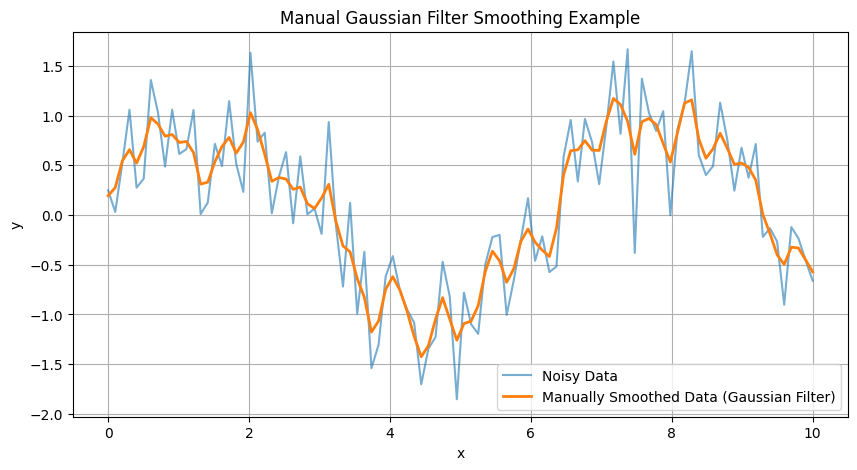

In [130]:
# Plot the original noisy data and the manually smoothed result
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Noisy Data', alpha=0.6)
plt.plot(x, smoothed_y_manual, label='Manually Smoothed Data (Gaussian Filter)', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Manual Gaussian Filter Smoothing Example')
plt.legend()
plt.grid(True)
plt.show()